<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW#1 </span>


<h1 align="center">Check Questions (15%)</h1> 

**Вопрос 1**: Опишите, как изменяется адаптивная способность алгоритма ЭСС при изменении параметра $\alpha$ от 0 до 1.

Чем меньше $\alpha$, тем сильнее сглаживание, меньше влияние последних значений, в т.ч. выбросов. В предельном случае $\alpha = 1 $ в качестве прогноза выдается текущее наблюдение.

**Вопрос 2**: Каким следует выбрать параметр сглаживания тренда $\alpha_2$ в модели Хольта (линейный тренд) в случае, когда вы предсказываете временной ряд 1) с плавно меняющимя трендом; 2) стохастически меняющися трендом?

2) Для оценки стохастического тренда нужна слабая чувствительность к шумам, берем маленькое значение параметра, а в случае (1) можно взять большой $\alpha_2$ для скорейшей адаптации к меняющемуся тренду

**Вопрос 3**: Докажите  эквивалетность формул расчёта (в рекуррентной форме и в форме корректировки прогноза (correction error form) )скрытых компонент временного ряда в модели Тейла-Вейджа (период сезонность обозначается $p$):

$$l_t = \alpha (y_t - s_{t-p}) + (1-\alpha) (l_{t-1} + b_{t-1} ) = \alpha (y_t - (s_{t-p} + l_{t-1} + b_{t-1})) + l_{t-1} + b_{t-1} = l_{t-1} + b_{t-1} + \alpha(\hat{y_t} - y_t) = l_{t-1} + b_{t-1} + \alpha e_t;$$,
$$ b_t = \beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1} = \beta(l_{t} - l_{t-1} - b_{t-1}) + b_{t-1} = \beta(\alpha e_t + l_{t-1} + b_{t-1}- l_{t-1} - b_{t-1}) + b_{t-1} = b_{t-1} + \alpha\beta e_t;$$,
$$ s_t = \gamma (y_t-l_t) + (1-\gamma) s_{t-p} = \gamma (y_t-l_t - s_{t-p}) + s_{t-p} = \gamma(y_t- (l_{t-1} + b_{t-1} + \alpha e_t) - s_{t-p}) +  s_{t-p} =  s_{t-p} + \gamma(y_t - \hat{y_t} - \alpha e_t)  = s_{t-p} + \gamma(1-\alpha)e_t.$$,

**Вопрос 4**: Выведите формулу расчёта скрытых компонент в форме корректировки прогноза (correction error form) временного ряда в модели ЭС с линейным затухающим трендом (WS with additive damped trend):

$$\hat{y}_{t+d|t} = l_t + \left(\phi + \phi^2 + \dots + \phi^{d}\right) b_t.$$,
   
Скрытые компоненты ВР согласно модели в рекуррентной форме записываются:
    $$ l_{t}       = \alpha y_t + \left(1-\alpha\right) \left(l_{t-1} +\phi b_{t-1}\right),$$,
    $$ b_t         = \beta \left(l_t - l_{t-1}\right) + \left(1-\beta\right)\phi b_{t-1}.$$


<Ответ>

<h1 align="center"> Practice</h1>
#  1. reading data (5%)

  * Download data for following data sets
     - 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv </span>(1 TS of monthly wage in Russia)

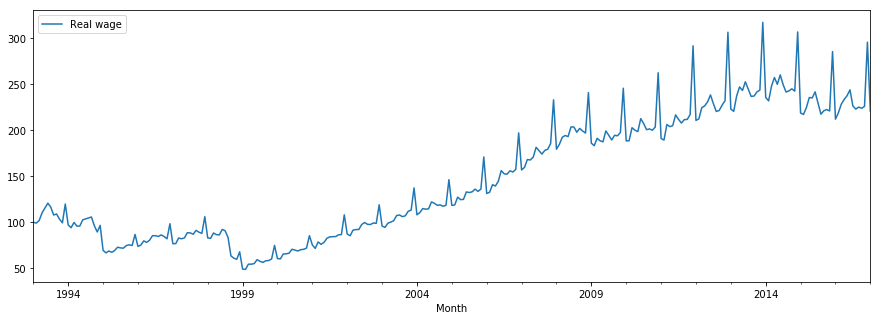

In [1]:
import pandas as pd
import numpy as np
from utils import InitExponentialSmoothing, plotTSForecast
from utils import qualityRMSE, qualityMedianAE, qualityMACAPE, qualitySSE, qualityMSE, qualityMAPE 
import os
import math

%matplotlib inline

# иначе не работает eval()
def BuildForecast(h, ts, AlgName, AlgTitle, ParamsArray, step='D'):
	FRC_TS = dict()
	for p in ParamsArray:
		frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
		frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)
		
		for cntr in ts.columns:
			frc_ts[cntr] = eval(AlgName)(ts[cntr], h, p)
		
#         frc_ts.columns = frc_ts.columns+('%s %s' % (AlgTitle, p))
		FRC_TS['%s %s' % (AlgTitle, p)] = frc_ts
	return FRC_TS


wage = pd.read_csv('monthly-wage.csv', sep=';', decimal='.', index_col= 0, parse_dates=True, dayfirst=True)
wage.plot(figsize=(15,5))

# 2. Build the Forecast with  IES (5%)

You need to apply IES model (see seminar 1) for the TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.


* 0) Forecast Wage TS with SES $\alpha=.1$.
* 1) Find the best param $\alpha$ of SES for data period from 09.1998 to 01.2015. Is the optimal value close to 0 or 1? (You 
can choose any loss function above).
* 2) Draw the forecast that correspond to IES with optimial value $\alpha$ (use time steps from 09.1998 to 01.2017.)
     Conclude whether IES can be used for this TS? If can not than explain why.
* 3) Calculate loss of the forecast of TS in [02.2015, 01.2017]. (You can choose any Loss function from seminar 1).

## 1) Search for the optimal $\alpha$ 

In [2]:
ALPHA = np.linspace(0.01,0.99,99)
ESParamsArray = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
FRC_WAGE = BuildForecast(h=1, ts=wage, AlgName ='InitExponentialSmoothing', AlgTitle='IES',ParamsArray = ESParamsArray)

In [3]:
# compare ES parameters
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE.keys())

ix = wage.loc['1998-09':'2015-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE[param_cntr]
    QualityStr[param_cntr],_ = qualityMACAPE(wage.loc[ix], frc_wage.loc[ix])

print(QualityStr[QualityStr.columns].mean().sort_values()[:10])

IES {'alpha': 0.41000000000000003, 'AdaptationPeriod': 10}    0.058955
IES {'alpha': 0.42000000000000004, 'AdaptationPeriod': 10}    0.058957
IES {'alpha': 0.40000000000000002, 'AdaptationPeriod': 10}    0.058959
IES {'alpha': 0.42999999999999999, 'AdaptationPeriod': 10}    0.058967
IES {'alpha': 0.39000000000000001, 'AdaptationPeriod': 10}    0.058974
IES {'alpha': 0.38, 'AdaptationPeriod': 10}                   0.058998
IES {'alpha': 0.44, 'AdaptationPeriod': 10}                   0.058998
IES {'alpha': 0.37, 'AdaptationPeriod': 10}                   0.059048
IES {'alpha': 0.45000000000000001, 'AdaptationPeriod': 10}    0.059093
IES {'alpha': 0.36000000000000004, 'AdaptationPeriod': 10}    0.059127
dtype: float64


## 2) draw the forecast with optimial value $\alpha $

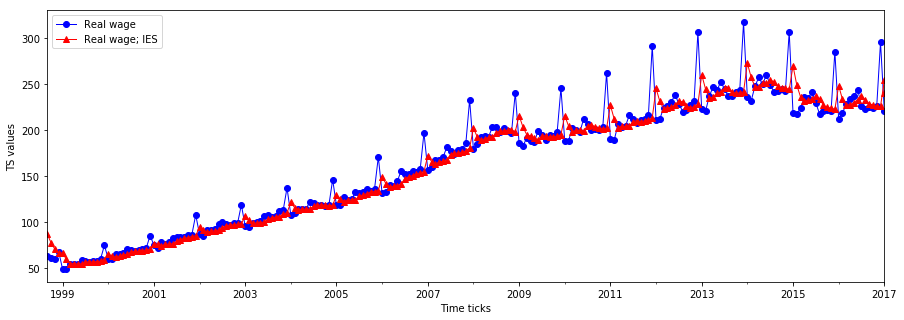

In [4]:
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage.loc['1998-09':'2017-01'], FRC_WAGE[algName].loc['1998-09':'2017-01']
               , ts_num=0, alg_title='IES')

Тренд предсказывается, но с сезонными ростами вообще никак. Они учитываются с опозданием в виде завышенного предсказания для первых месяцев нового года, где на самом деле провал. Эксп. сглаживание не подходит для зарплат по месяцам.

## 3) Calculate loss of the forecast of TS in [02.2015, 01.2017]

In [5]:
qualityMACAPE(wage.loc['2015-02':'2017-01'], FRC_WAGE[algName].loc['2015-02':'2017-01'])[0]

Real wage    0.0629
dtype: float64

# 3. Winters model for Additive Seasonality (25%)

In [6]:
# Start with this code
###################### Winters Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    delts <scalar in [0,1]> - seasonality smoothing parameter

def WintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    delta = Params['delta']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN] * (T + h)
    if alpha > 1 or alpha < 0 or delta > 1 or delta < 0 or p < 1:
        return FORECAST
    
    l = np.NaN
    s = [np.NaN] * p
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = 0
 
            if math.isnan(s[cntr % p]):
                s[cntr % p] = 0
 
            l_old = l
            l = alpha * (x[cntr] - s[cntr % p]) + (1 - alpha) * l_old
            s[cntr % p] = delta * (x[cntr] - l_old) + (1 - delta) * s[cntr % p]
            
        FORECAST[cntr+h] = l + s[(cntr+h) % p]

    return FORECAST

In [7]:
def params_grid_search(FRC_WAGE, QualityStr):
    ix = wage.loc['1998-09':'2015-01'].index
    for param_cntr in sorted(QualityStr.columns):
        frc_wage = FRC_WAGE[param_cntr]
        QualityStr[param_cntr],_ = qualityMACAPE(wage.loc[ix], frc_wage.loc[ix])
    return QualityStr[QualityStr.columns].mean().sort_values()[:10]

In [8]:
# поиск оптимальных параметров
ALPHA = np.linspace(0.1,1,10)
DELTA = np.linspace(0.1,1,10)
WintersParamsArray = [{'alpha':alpha, 'delta':delta, 'seasonality_period':12} for alpha in ALPHA for delta in DELTA]

FRC_WAGE = BuildForecast(h=1, ts=wage, AlgName = 'WintersExponentialSmoothing', AlgTitle='Winters'
                              ,ParamsArray = WintersParamsArray, step='MS')
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE.keys())
print (params_grid_search(FRC_WAGE, QualityStr))

Winters {'alpha': 0.5, 'delta': 0.59999999999999998, 'seasonality_period': 12}                    0.028548
Winters {'alpha': 0.40000000000000002, 'delta': 0.59999999999999998, 'seasonality_period': 12}    0.028829
Winters {'alpha': 0.5, 'delta': 0.5, 'seasonality_period': 12}                                    0.029024
Winters {'alpha': 0.5, 'delta': 0.70000000000000007, 'seasonality_period': 12}                    0.029025
Winters {'alpha': 0.59999999999999998, 'delta': 0.40000000000000002, 'seasonality_period': 12}    0.029140
Winters {'alpha': 0.5, 'delta': 0.40000000000000002, 'seasonality_period': 12}                    0.029245
Winters {'alpha': 0.40000000000000002, 'delta': 0.70000000000000007, 'seasonality_period': 12}    0.029344
Winters {'alpha': 0.40000000000000002, 'delta': 0.5, 'seasonality_period': 12}                    0.029349
Winters {'alpha': 0.70000000000000007, 'delta': 0.40000000000000002, 'seasonality_period': 12}    0.029584
Winters {'alpha': 0.59999999999999998

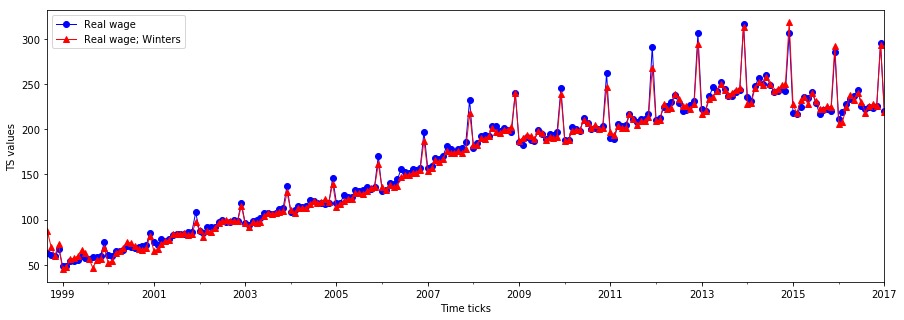

In [9]:
# График
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage.loc['1998-09':'2017-01'], FRC_WAGE[algName].loc['1998-09':'2017-01']
               , ts_num=0, alg_title='Winters')

In [10]:
print("Quality: {}".format(qualityMACAPE(wage.loc['2015-02':'2017-01'], FRC_WAGE[algName].loc['2015-02':'2017-01'])[0]))

Quality: Real wage    0.016181
dtype: float64


На наших данных модель Уинтерса с аддитивной сезонностью прогнозирует очень хорошо

# 4. Theil-Wage model for TS with linear trend and seasonality (25%)

In [11]:
def Theil_Wage_Model(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    delta = Params['delta']
    p = Params['seasonality_period']

    FORECAST = [np.NaN] * (T + h)
    if alpha > 1 or alpha < 0 or delta > 1 or delta < 0 or p < 1:
        return FORECAST
    
    l = np.NaN
    s = [np.NaN] * p
    b = np.NaN 
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = 0
 
            if math.isnan(s[cntr % p]):
                s[cntr % p] = 0
            
            if math.isnan(b):
                b = 0
            
            l_old = l
            b_old = b
            
            l = alpha * (x[cntr] - s[cntr % p]) + (1 - alpha) * (l_old + b_old)
            b = beta * (l - l_old) + (1 - beta) * b_old
            s[cntr % p] = delta * (x[cntr] - l) +  (1 - delta) * s[cntr % p]

            
        FORECAST[cntr + h] = l + h * b + s[(cntr + h) % p]
    return FORECAST

In [12]:
ALPHA = np.linspace(0.1,1,10)
DELTA = np.linspace(0.1,1,10)
BETA = np.linspace(0.01, 0.2, 10)
TheilWageParamsArray = [{'alpha':alpha, 'delta':delta, 'beta':beta, 'seasonality_period':12} for alpha in ALPHA for delta in DELTA for beta in BETA]
FRC_WAGE = BuildForecast(h=1, ts=wage, AlgName = 'Theil_Wage_Model', AlgTitle='Theil Wage'
                              ,ParamsArray = TheilWageParamsArray, step='MS')

QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE.keys())
print (params_grid_search(FRC_WAGE, QualityStr))

Theil Wage {'alpha': 0.40000000000000002, 'delta': 1.0, 'beta': 0.01, 'seasonality_period': 12}                                    0.025717
Theil Wage {'alpha': 0.40000000000000002, 'delta': 0.90000000000000002, 'beta': 0.03111111111111111, 'seasonality_period': 12}     0.026168
Theil Wage {'alpha': 0.40000000000000002, 'delta': 0.90000000000000002, 'beta': 0.01, 'seasonality_period': 12}                    0.026211
Theil Wage {'alpha': 0.40000000000000002, 'delta': 1.0, 'beta': 0.03111111111111111, 'seasonality_period': 12}                     0.026510
Theil Wage {'alpha': 0.40000000000000002, 'delta': 0.80000000000000004, 'beta': 0.03111111111111111, 'seasonality_period': 12}     0.026811
Theil Wage {'alpha': 0.40000000000000002, 'delta': 0.90000000000000002, 'beta': 0.052222222222222225, 'seasonality_period': 12}    0.026814
Theil Wage {'alpha': 0.40000000000000002, 'delta': 0.80000000000000004, 'beta': 0.052222222222222225, 'seasonality_period': 12}    0.026915
Theil Wage {'alpha':

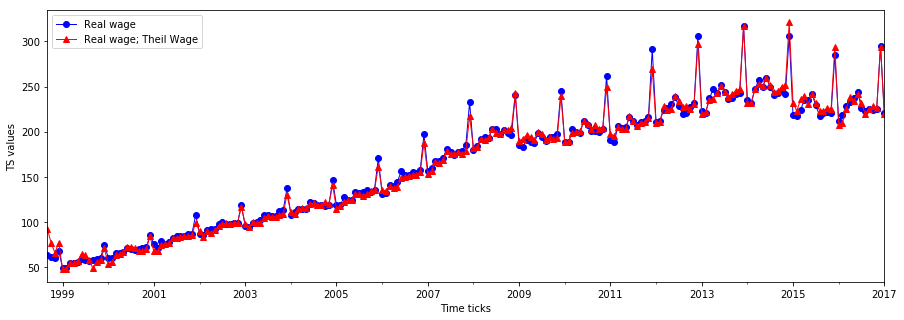

In [13]:
# График
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage.loc['1998-09':'2017-01'], FRC_WAGE[algName].loc['1998-09':'2017-01']
               , ts_num=0, alg_title='Theil Wage')

In [14]:
print("Quality: {}".format(qualityMACAPE(wage.loc['2015-02':'2017-01'], FRC_WAGE[algName].loc['2015-02':'2017-01'])[0]))

Quality: Real wage    0.017475
dtype: float64


Практически та же точность, что и у в случае применения Уинтерса. 

# 5. Non-additive model of ES (25%)
You need to realize some ES-model that include non-addive component (or multiplicative trend or multiplicative component) and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize one of following ES models: ESM(A,M) (t.e. Holt-Winters model), ESM(Ad,M), ESM(M,A), ESM(M,M) model.
* 2) Find optimal params of the model (use data from 09.1998 to 01.2015). Note: if you choose damped trend model that $\phi$ you can just set it by expert opinion (say $0.98$). (Loss function should be the same as in task 2.)
* 3) Draw forecast with optimal values of it's params (data from 09.1998 to 01.2017). 
* 4) Calculate accuracy of the forecast of TS in [02.2015, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of Winters model and Theil-Wage model: is it better than the last one? 
* 5) Is it true that multiplicative model are more unstable than additive? Unstable means thet forecast is can diveret

In [15]:
def AM_Model(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    delta = Params['delta']
    p = Params['seasonality_period']

    FORECAST = [np.NaN] * (T + h)
    if alpha > 1 or alpha < 0 or delta > 1 or delta < 0 or p < 1:
        return FORECAST
    
    l = np.NaN
    s = [np.NaN] * p
    b = np.NaN 
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = 1
 
            if math.isnan(s[cntr % p]):
                s[cntr % p] = 1
            
            if math.isnan(b):
                b = 1
            
            l_old = l
            b_old = b
            
            l = alpha * (x[cntr] / s[cntr % p]) + (1 - alpha) * (l_old + b_old)
            b = beta * (l - l_old) + (1 - beta) * b_old
            s[cntr % p] = delta * x[cntr] / (l_old + b_old) +  (1 - delta) * s[cntr % p]

            
        FORECAST[cntr + h] = (l + h * b) * s[(cntr + h) % p]
    return FORECAST

In [16]:
ALPHA = np.linspace(0.1,1,10)
DELTA = np.linspace(0.1,1,10)
BETA = np.linspace(0.1, 1, 10)
AMParamsArray = [{'alpha':alpha, 'delta':delta, 'beta':beta, 'seasonality_period':12} for alpha in ALPHA for delta in DELTA for beta in BETA]
FRC_WAGE = BuildForecast(h=1, ts=wage, AlgName = 'AM_Model', AlgTitle='AM'
                              ,ParamsArray = AMParamsArray, step='MS')

QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE.keys())
print (params_grid_search(FRC_WAGE, QualityStr))

AM {'alpha': 0.40000000000000002, 'delta': 0.70000000000000007, 'beta': 0.10000000000000001, 'seasonality_period': 12}    0.029057
AM {'alpha': 0.30000000000000004, 'delta': 0.59999999999999998, 'beta': 0.20000000000000001, 'seasonality_period': 12}    0.031657
AM {'alpha': 0.30000000000000004, 'delta': 0.70000000000000007, 'beta': 0.10000000000000001, 'seasonality_period': 12}    0.031672
AM {'alpha': 0.40000000000000002, 'delta': 0.80000000000000004, 'beta': 0.10000000000000001, 'seasonality_period': 12}    0.032479
AM {'alpha': 0.30000000000000004, 'delta': 0.59999999999999998, 'beta': 0.10000000000000001, 'seasonality_period': 12}    0.032649
AM {'alpha': 0.30000000000000004, 'delta': 0.5, 'beta': 0.30000000000000004, 'seasonality_period': 12}                    0.034417
AM {'alpha': 0.30000000000000004, 'delta': 0.80000000000000004, 'beta': 0.10000000000000001, 'seasonality_period': 12}    0.034617
AM {'alpha': 0.30000000000000004, 'delta': 0.5, 'beta': 0.10000000000000001, 'seaso

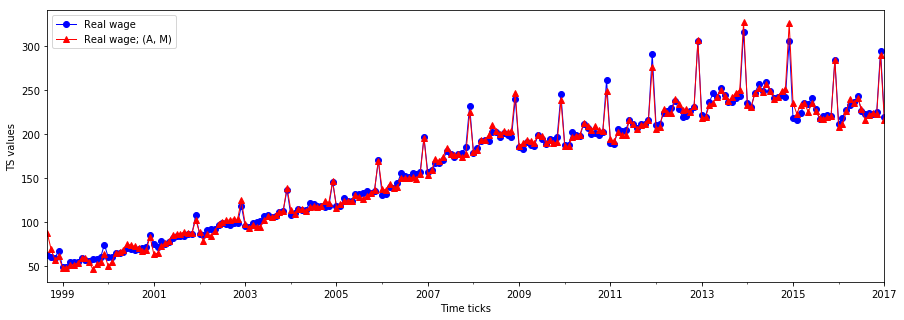

In [17]:
# График
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage.loc['1998-09':'2017-01'], FRC_WAGE[algName].loc['1998-09':'2017-01']
               , ts_num=0, alg_title='(A, M)')

In [18]:
print("Quality: {}".format(qualityMACAPE(wage.loc['2015-02':'2017-01'], FRC_WAGE[algName].loc['2015-02':'2017-01'])[0]))

Quality: Real wage    0.016345
dtype: float64


Все три модели пригодны для прогнозирования зарплат. Сделать более точных выводов и сравнить их между собой по графикам и loss-функциям нельзя: точность очень близка друг к другу, а вся разница может компенсироваться лучшим подбором стартовых значений и значений параметров (альфа, ...). 